# Counting analysis 🚀🚀

In this notebook, we will look at frequencies of biblicle text on the following syntax levels:

* word: part of speech
* phrase: function, type
* clause: type

## Import main libraries

In [118]:
#Data
from functions.bhsa import get_data, unique, lbh_books, sbh_books # <- here's the new data data load statement -CK

#Storing data
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt

#Frequency counting
import collections
from itertools import chain

#Plotting frequencies
from numpy.polynomial import Polynomial

#Correlation
from scipy.stats import pearsonr, kendalltau, spearmanr
import math

#Confidence interval
import scipy as sp
import scipy.stats

#Distance functions
from scipy.spatial.distance import pdist, squareform

#Hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet, fcluster, inconsistent, is_valid_linkage


In [3]:
all_data = get_data()

## Data

In [18]:
print("Lbh_books:",lbh_books)
print("Sbh_books:",sbh_books)

Lbh_books: {'Nehemiah', 'Ezra', '2_Chronicles', '1_Chronicles', 'Esther'}
Sbh_books: {'Leviticus', 'Joshua', 'Exodus', 'Deuteronomy', '2_Kings', '1_Samuel', '2_Samuel', '1_Kings', 'Genesis', 'Judges'}


In [19]:
level = "phrase_functions"

data = all_data[level]

unique_functions = unique(otype='phrase', feature='function') 

print("Level: ", level)
print("Unique functions:",unique_functions)

Level:  phrase_functions
Unique functions: ['Pred', 'Conj', 'Subj', 'Cmpl', 'Objc', 'PreC', 'Adju', 'Rela', 'Nega', 'PreO', 'Time', 'Modi', 'Loca', 'Intj', 'Voct', 'Ques', 'Frnt', 'PreS', 'NCop', 'IntS', 'PrAd', 'Supp', 'PtcO', 'Exst', 'NCoS', 'ModS', 'EPPr', 'ExsS', 'PrcS']


## Counting frequencies

We want to count the occurences of feature values. Therefore, two matrices should be computed: one with the raw counts of feature values and one for the probabilisties on each feature value for each book. This means that all raw count are divided by the sum of feature values.

In [5]:
def make_counts(feature_dict):
    '''
    Return a dictionary with frequency counts of the feature values.
    Requires a feature dict: feature[book] = list(list()*N)
    '''
    feature_count = dict() # counts here

    # loop and count
    for bookname, units in feature_dict.items():
        feature_count[bookname] = collections.Counter(list(chain(*units))) 

    # make into dataframe
    df_Count = pd.DataFrame(feature_count, columns=feature_dict.keys()).fillna(0)
    df_Prob = df_Count.div(df_Count.sum(axis=0), axis=1)
    
    # return both count and probability objects
    return  df_Count, df_Prob

In [6]:
df_Count, df_Prob = make_counts(data)
df_Count.head(10)

,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Adju,173.0,1136,168.0,19.0,59.0,115.0,99.0,76.0,103.0,169.0,155.0,60.0,842,79.0,84.0,243.0,376.0
Cmpl,1252.0,6877,563.0,155.0,222.0,665.0,805.0,899.0,746.0,752.0,818.0,211.0,1895,109.0,288.0,416.0,871.0
Conj,2621.0,12890,1211.0,219.0,338.0,988.0,1426.0,1778.0,1388.0,1422.0,1499.0,288.0,3407,189.0,525.0,837.0,1568.0
Exst,4.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,3.0,0.0,0.0
Frnt,14.0,100,12.0,0.0,0.0,10.0,5.0,9.0,9.0,28.0,13.0,1.0,37,2.0,2.0,10.0,22.0
IntS,1.0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,12,0.0,0.0,2.0,10.0
Intj,42.0,141,12.0,1.0,2.0,3.0,18.0,20.0,12.0,15.0,16.0,0.0,7,0.0,1.0,0.0,6.0
Loca,120.0,663,122.0,8.0,25.0,55.0,57.0,61.0,56.0,79.0,80.0,11.0,214,17.0,53.0,41.0,92.0
ModS,4.0,11,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,0.0,1.0,1,0.0,0.0,0.0,0.0
Modi,86.0,408,52.0,8.0,9.0,36.0,37.0,49.0,51.0,45.0,35.0,8.0,98,7.0,19.0,24.0,40.0


As can be seen, each column contains zeros or is below 5. Therefore, we cannot compute a chi-square test to test whether the frequencies of feature values is significant different between books. http://www.simafore.com/blog/bid/56480/2-key-assumptions-to-be-aware-of-before-applying-the-chi-square-test.

# Plotting the frequencies between books

We want to know how similar or dissimilar the frequencies of feature values between books are. Therefore, we may want to plot the frequencies of different feature values from book A and compare these with the frequencies of the same feature values from a book B. We interpret each column as a vector and plot the values of these vectors against another. 

In [72]:
def plot_occurences(df, books):
    '''
    Plot each frequency 
    '''
    axs = pd.plotting.scatter_matrix(df[books], figsize=(20, 20), alpha=1,diagonal="kde", color='red', s=100)
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            if(indexi!=indexj):
                x = np.array(df[i].values)
                y = np.array(df[j].values)
                p = Polynomial.fit(x, y, 1)
                axs[indexj, indexi].plot(*p.linspace(), color='blue') #Plot the line
    
    plt.show()

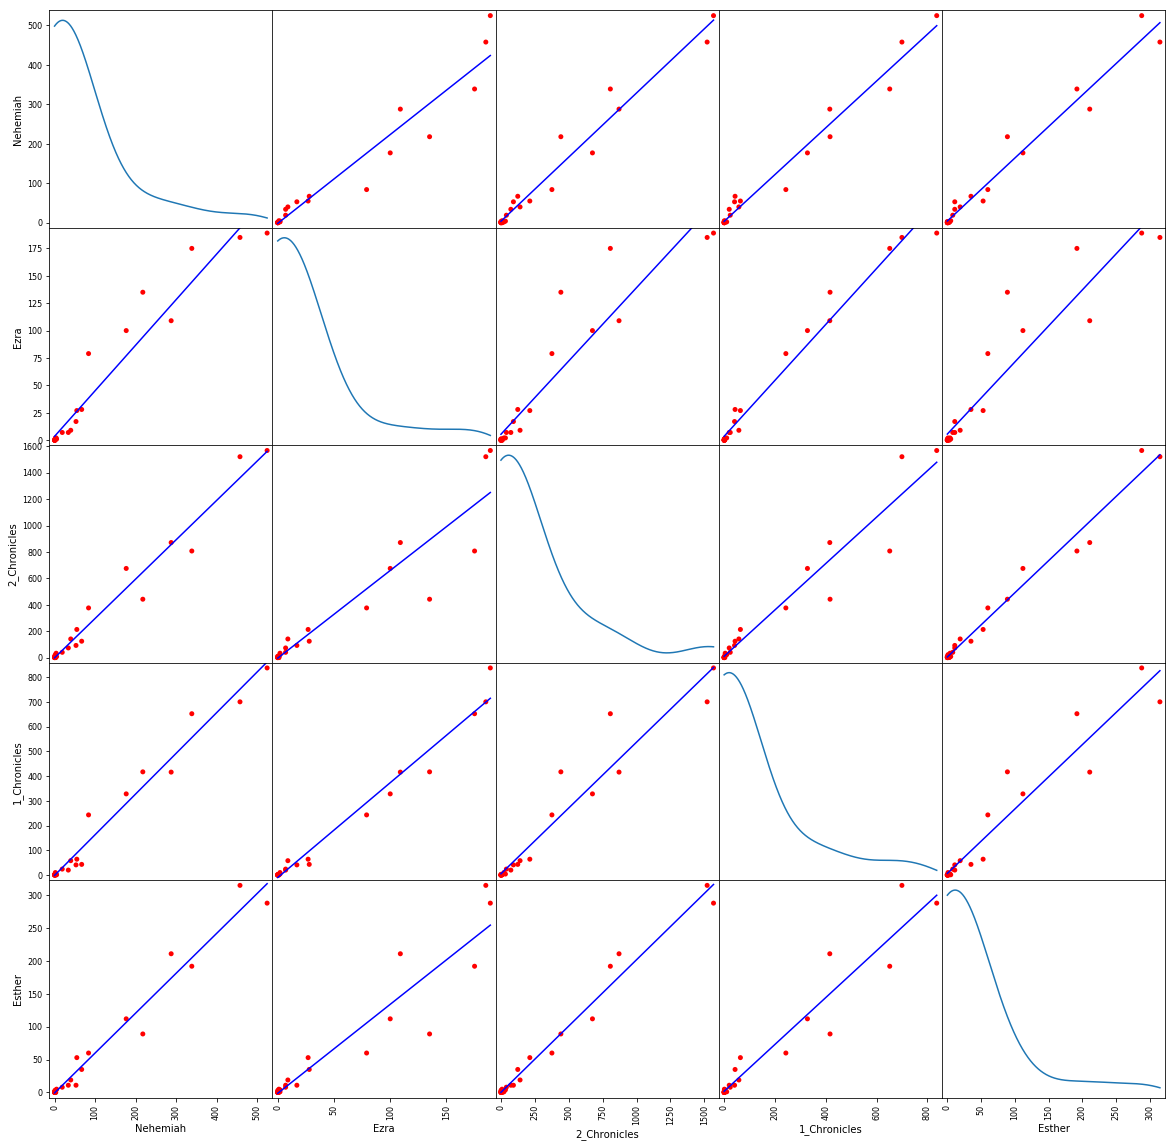

In [75]:
plot_occurences(df_Count, list(lbh_books))

We can observe here that books where the points are closer to the straight line are more similar than books where this is not the case. We can also see that there is a positive correlation between the number of frequencies. Similar books show that a higher number of occurences in book A will also occur in book B. We want thus some measure that indicates how similar the books in frequencies are or how dissimilar. 

# Distance measurements frequencies

In the simplest form distance measures are mathematical approaches to measure distance between the objects. Computing distance measures helps us to compare the objects from three different standpoints such as.
* Similarity are measure that range from 0 to 1 [0, 1]
* Dissimilarity is measures that range from 0 to INF [0, Infinity]
* Correlation is measures that range from +1 to -1 [+1, -1]


http://shakthydoss.com/technical/distance-measures-similarity-dissimilarity-correlation/

## Distance functions

Measurements:
(s,sq)euclidean, (w)minkowski, cosine, canberra, braycurtis, mahalanobis, other f

These distances are to be forgotten: 
* Boolean vectors: yule,dice, rogerstanimoto, russellrao,sokalmichener,sokalsneath,kulsinski
* Manhatten distance: cityblock
* Strings: hamming
* Number of same frequency/ n: jaccard
* max norm distance: chebyshev

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

## Correlation

"Correlation is a bivariate analysis that measures the strength of association between two variables and the direction of the relationship. In terms of the strength of relationship, the value of the correlation coefficient varies between +1 and -1.  A value of ± 1 indicates a perfect degree of association between the two variables.  As the correlation coefficient value goes towards 0, the relationship between the two variables will be weaker.  The direction of the relationship is indicated by the sign of the coefficient; a + sign indicates a positive relationship and a – sign indicates a negative relationship."

http://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

In correlation tests, we want to test whether two variables are dependent. In these tests, the null hypothesis that could be rejected is that two variables are independent. 

Bijma, F., Gunst, de M.C.M. (2015) Statistical Data Analysis. VU University Amsterdam

Correlation is a statistical technique that gives a number telling how strongly or weekly the relationship between the objects. It is not a measure describing the distance but a measure describes the bound between the objects.

http://shakthydoss.com/technical/distance-measures-similarity-dissimilarity-correlation/

#### Pearson correlation

The pearson does assume that both X and Y come from a bivariat normal distribution. Therefore this is a parametric distribution. Since the frequencies are not normally distributed, this test is not appropriate. 

Chen, P. Y., & Popovich, P. M. (2002). Correlation: Parametric and nonparametric measures. Thousand Oaks, CA: Sage Publications page 13-14 https://rufiismada.files.wordpress.com/2012/02/correlation__parametric_and_nonparametric_measures__quantitative_applications_in_the_social_sciences_.pdf 


#### Spearman rank correlation

This test is a non-parametric test that is used to measure the dependency between variables. For the Spearmann test, the null hypothesis is rejected if the statistic is close to -1 or 1. The assumptions of the Spearman correlation are that data must be at least ordinal and the scores on one variable must be monotonically related to the other variable. 


#### Kendall rank correlation

Kendall is a non-parametric test that looks at the relation between two variables.

Kendall: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kendalltau.html
Pearson: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html
Spearman:https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html




### Correlation as distance

Suggested in the under mentioned websites are the four following versions of transforming correlation to distance:
* 1) Dissimilarity = 1 - Correlation
* 2) Dissimilarity = (1 - Correlation)/2
* 3) Dissimilarity = 1 - Abs(Correlation)
* 4) Dissimilarity = Sqrt(1 - Correlation^2 ) 

3) http://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/pear_dis.htm
4) http://84.89.132.1/~michael/stanford/maeb6.pdf

http://research.stowers.org/mcm/efg/R/Visualization/cor-cluster/index.htm

Restrictions on clustering with correlations
https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering

## Functions for distances

In [98]:
#Correlation
def pearsonCorrelation(x, y):#Maybe not use this by rejecting assumption normallity
    "Returns stats, p"
    return pearsonr(x,y)

def kendaltauCorrelation(x,y): #Only valid I Guess
    "Returns stats, p"
    return kendalltau(x,y)

def spearmanCorrelation(x,y): #Problem with ties
    "returns rho, p"
    return spearmanr(x,y)

#Convert correlation and score to distance
def to_distance(value, method):
    "Uses one of the transformation function to convert value to distance"
    if method == 1:
        return 1-value
    elif method == 2:
        return math.sqrt(1-value*value)
    elif method == 3:
        return (1-value)/2
    elif method == 4:
        return (1-abs(value))
    return value
    
def correlationDistance(x,y,correlationMethod,distanceMethod):
    if correlationMethod == "pearson":
        statistic, p_value  = pearsonCorrelation(x,y)
    elif correlationMethod == "spearman":
        statistic, p_value = spearmanCorrelation(x,y)
    else:
        statistic, p_value = kendaltauCorrelation(x,y)
    return to_distance(statistic,distanceMethod)

## Create distance metric


A distance metric should have the following properties: 
* Distance positive
* Distance to itself should be 0
* Symmetric distances
* Triangle inequality

https://en.wikipedia.org/wiki/Metric_(mathematics)

### Functions for distance metric

In [154]:
def createCorrelationDistanceMetric(df, books, correlationMethod,distanceMethod):
    df_dist = pd.DataFrame(np.zeros((len(books),len(books))), columns = books, index = books)
    
    for indexi, i in enumerate(books):
        for indexj, j in enumerate(books):
            x = np.array(df[i].values)
            y = np.array(df[j].values)
            
            dist = correlationDistance(x,y,correlationMethod, distanceMethod)
            df_dist.loc[i,j] = round(dist,7)
    return df_dist

def pairWiseDistances(df, method):
    df_dist = pdist(df,method)
    return df_dist

## Original distance metric

In [159]:
df_Count1 = df_Count.drop(["sbh","lbh"], 1) 

df_Dist = createCorrelationDistanceMetric(df_Count1, list(df_Count1),"kendall",1)
df_vector = squareform(df_Dist)

a = pairWiseDistances(np.matrix(df_Count1.values).T,"correlation")
df_Dist

,Genesis,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,0.105313,0.117707,0.237564,0.130967,0.106208,0.114819,0.084662,0.100666,0.112594,0.164143,0.123074,0.154400,0.183263,0.192526
Exodus,0.105313,0.000000,0.149997,0.227994,0.147755,0.104598,0.127127,0.096546,0.109132,0.131562,0.181165,0.150675,0.170983,0.190196,0.178675
Leviticus,0.117707,0.149997,0.000000,0.130583,0.094057,0.153639,0.152196,0.098390,0.143530,0.113247,0.155074,0.168253,0.180598,0.157268,0.148573
Deuteronomy,0.237564,0.227994,0.130583,0.000000,0.174995,0.220670,0.222827,0.174699,0.207309,0.147025,0.215528,0.261203,0.239836,0.246007,0.205401
Joshua,0.130967,0.147755,0.094057,0.174995,0.000000,0.137575,0.125612,0.098046,0.103729,0.084817,0.163073,0.124738,0.159773,0.090550,0.076647
Judges,0.106208,0.104598,0.153639,0.220670,0.137575,0.000000,0.076660,0.107681,0.099819,0.108469,0.122519,0.182592,0.164364,0.204033,0.168653
1_Samuel,0.114819,0.127127,0.152196,0.222827,0.125612,0.076660,0.000000,0.075337,0.108454,0.137510,0.166010,0.170610,0.193814,0.192276,0.156997
2_Samuel,0.084662,0.096546,0.098390,0.174699,0.098046,0.107681,0.075337,0.000000,0.108797,0.110700,0.173566,0.146516,0.187606,0.158198,0.154105
1_Kings,0.100666,0.109132,0.143530,0.207309,0.103729,0.099819,0.108454,0.108797,0.000000,0.062393,0.109776,0.155181,0.168595,0.128870,0.108454
2_Kings,0.112594,0.131562,0.113247,0.147025,0.084817,0.108469,0.137510,0.110700,0.062393,0.000000,0.146146,0.174824,0.170605,0.141196,0.110345


## Bootstrapping distance metric

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5708128/

In [13]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

In [403]:
mean_confidence_interval(correlations)

(0.20567116340486177, 0.20510808225449437, 0.20623424455522918)

In [242]:
def bootstrappingMethod(feature_dict):
    
    bootstrap = {}
    for i in range(100):
        feature_dict_bootstrap = {}
        
        for bookname, units in feature_dict.items():
            feature_dict_bootstrap[bookname] = np.random.choice(units, len(units))
            
        df_Count_bootstrap, none = make_counts(feature_dict_bootstrap)
        df_Count_bootstrap = df_Count_bootstrap.drop(["sbh","lbh"], 1) 
        
        
        df_Dist = createCorrelationDistanceMetric(df_Count_bootstrap, list(df_Count_bootstrap),"spearman",1)
        #df_Dist = pairWiseDistances(np.matrix(df_Count1.values).T,"cosine")
        #bootstrap[i] = df_Dist
        bootstrap[i] = squareform(df_Dist)
        

    return bootstrap
        
    

In [243]:
B = bootstrappingMethod(data)
results = pd.DataFrame(B)
mean = results.mean(1)
df_dist = pd.DataFrame(squareform(mean), columns=df_Count1.keys(), index=df_Count1.keys())
df_dist
#results

,Genesis,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,0.031691,0.057087,0.091459,0.042313,0.033761,0.029777,0.030562,0.037972,0.041736,0.078561,0.062816,0.066981,0.075884,0.067418
Exodus,0.031691,0.000000,0.075166,0.094040,0.046476,0.038241,0.036251,0.032814,0.035813,0.039312,0.093318,0.066696,0.074331,0.072714,0.060178
Leviticus,0.057087,0.075166,0.000000,0.067234,0.056032,0.081444,0.068441,0.052516,0.080899,0.067406,0.089711,0.084806,0.093269,0.079448,0.077805
Deuteronomy,0.091459,0.094040,0.067234,0.000000,0.068206,0.088984,0.080716,0.066882,0.093741,0.061167,0.096363,0.104522,0.102295,0.102464,0.082035
Joshua,0.042313,0.046476,0.056032,0.068206,0.000000,0.065703,0.042211,0.031824,0.043266,0.033942,0.078584,0.051133,0.073238,0.033737,0.032101
Judges,0.033761,0.038241,0.081444,0.088984,0.065703,0.000000,0.026006,0.045274,0.033274,0.042901,0.067523,0.087254,0.074025,0.091170,0.067823
1_Samuel,0.029777,0.036251,0.068441,0.080716,0.042211,0.026006,0.000000,0.027561,0.034874,0.044124,0.077575,0.072477,0.076091,0.073714,0.052115
2_Samuel,0.030562,0.032814,0.052516,0.066882,0.031824,0.045274,0.027561,0.000000,0.046789,0.041229,0.087994,0.068288,0.086849,0.068430,0.062002
1_Kings,0.037972,0.035813,0.080899,0.093741,0.043266,0.033274,0.034874,0.046789,0.000000,0.026936,0.060290,0.070324,0.071632,0.054684,0.040436
2_Kings,0.041736,0.039312,0.067406,0.061167,0.033942,0.042901,0.044124,0.041229,0.026936,0.000000,0.074035,0.076747,0.076819,0.057987,0.041701


## Hierarchical distance 

In [248]:
methods = {"single","complete","average","weighted","median","centroid","ward"}

#LOOCV
LOOCV = {}
for book in df_Count1:
    df_Temp = df_Count1.drop(book, 1)
    Methoc_c = {}
    for method in methods:

        X = createCorrelationDistanceMetric(df_Temp, list(df_Temp.keys()),"spearman",1)
        X = squareform(X)
        
        #X = pdist(np.matrix(df_Temp.values), 'cosine')
        Y = X
        Z1 = linkage(X,method)
        c, coph_dists = cophenet(Z1,Y)
        Methoc_c[method] = c
    LOOCV[book] = Methoc_c
df_LOOCV = pd.DataFrame(LOOCV)

print(df_LOOCV.mean(axis=1))
df_LOOCV.std(axis=1)

average     0.758978
centroid    0.781597
complete    0.710612
median      0.792591
single      0.750073
ward        0.662657
weighted    0.729151
dtype: float64


average     0.040403
centroid    0.042058
complete    0.052056
median      0.037817
single      0.045502
ward        0.035378
weighted    0.039017
dtype: float64

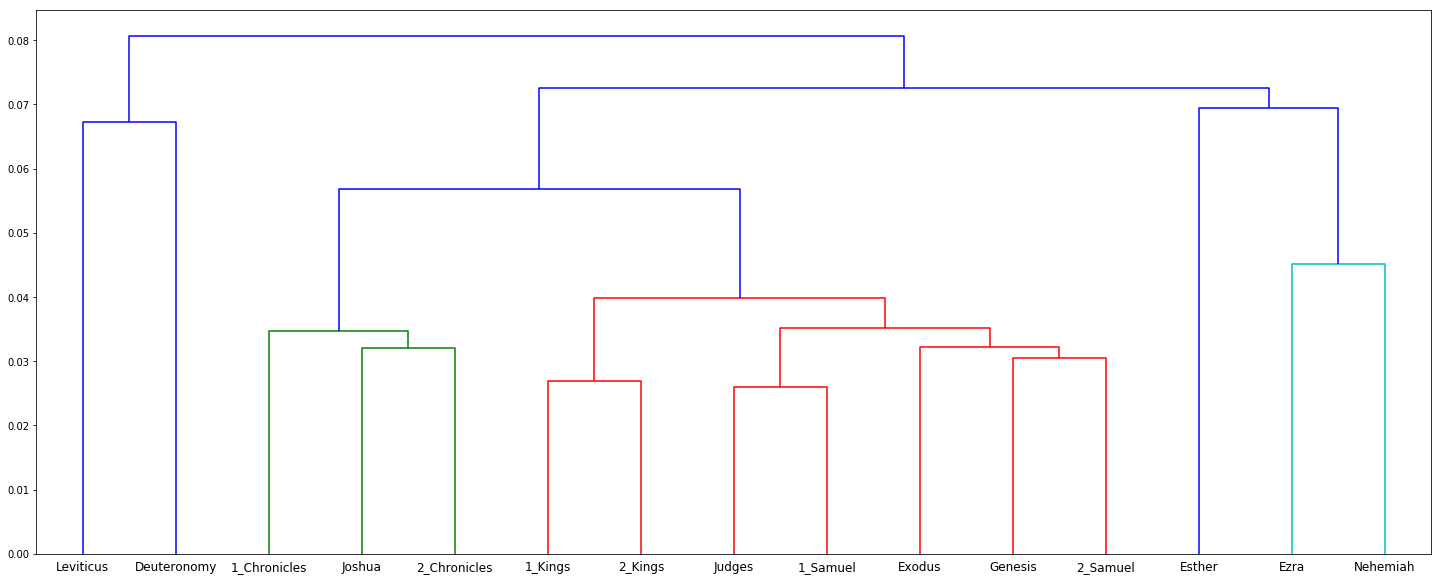

In [245]:
Z1 = linkage(mean,"average")
plt.figure(figsize=(25, 10))
dendrogram(Z1,labels = list(df_Count1))
plt.show()


## Hierarchical Clustering

Tutorial in hierarchical clustering
http://people.revoledu.com/kardi/tutorial/Clustering/Distance%20Matrix.htm
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

Methods to do hierarchical clustering
* Single
* Complete
* Average
* Weighted
* Ward
* Median
* Centroid

Usage in python
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html


## Functions for clustering

In [11]:
def hierarchical_clustering1(distanceMatrix, method, books):
    Z = linkage(distanceMatrix,  method)
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels = books)
    plt.show()
    
def hierarchical_clustering2(df_Count, method, distancemeasure, books):
    Z = linkage(df_Count,  method, distancemeasure)
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels = books)
    plt.show()

# Analysis

option clustering :Single,Complete,Average,Weighted,Ward,Median,Centroid

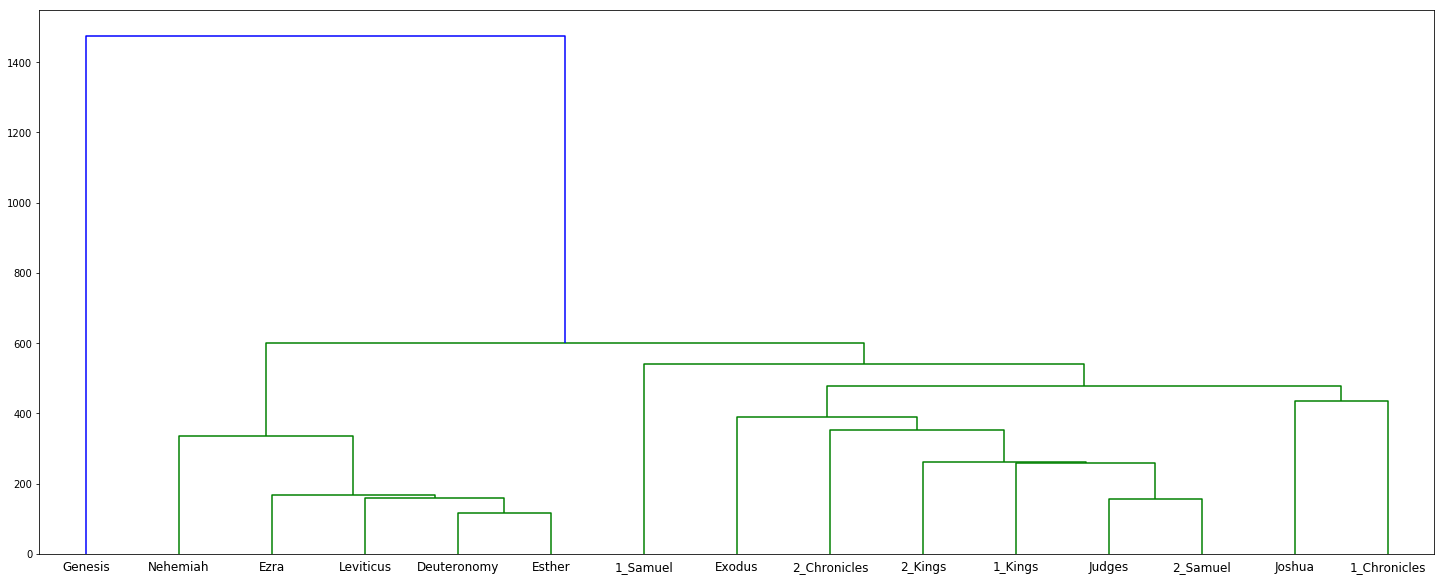

In [203]:
#hierarchical_clustering1(np.matrix(df_Dist.values),"single", list(df_Count1))
hierarchical_clustering2(np.matrix(df_Count1.values).transpose(),"single", "euclidean", list(df_Count1))

## Clustering on distances
